<a href="https://colab.research.google.com/github/Byeon-MJ/TIL/blob/main/%5BDL%5D_PyTorch_DNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch DNN 구현하기

* torch.utils.data
    * 데이터셋의 표준을 정의
    * 불러오고, 자르고 섞는데 쓰는 도구들이 들어있음
    * torch.utils.data.DataLoader 인스턴스의 입력으로 사용가능
* torchvision.datasets
    * torch.utils.data.Dataset을 상속하는 이미지 데이터셋의 모음
* torchvision.transforms
    * 이미지 데이터셋에 쓸 수 있는 여러가지 변환 필터를 담고있는 모듈
* torchvision.utils
    * 이미지 데이터를 저장하고 시각화 하기 위한 도구를 담고있는 모듈

In [17]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torchvision import datasets, transforms, utils
from torch.utils import data

## Prepare Dataset : FashionMNIST

**Transforms**
* ToTensor : 이미지(ndarray)를 텐서로 변환
* Resize : 이미지 크기 조정
* Normalize : 주어진 평균과 표준편차를 이용하여 정규화
* RandomHorizontalFlip : 좌우 반전
* RandomCrop : 이미지 무작위 자르기

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

### Dataset Download

In [5]:
# torchvision datasets 패키지
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,           # 훈련셋 설정
    download = True,
    transform = transform   # 미리 설정한 transform 사용
)
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False,          # 시험셋 설정
    download = True,
    transform = transform   # 미리 설정한 transform 사용
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./.data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./.data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./.data/FashionMNIST/raw



### Set Variable

In [18]:
EPOCHS = 30
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda' if USE_CUDA else 'cpu')
print(DEVICE)

cuda


### Create DataLoader

In [8]:
# 입력한 데이터셋을 BATCH_SIZE만큼 로드해서 사용
train_loader = data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True
)
test_loader = data.DataLoader(
    dataset = testset,
    batch_size = BATCH_SIZE,
    shuffle = True
)

### Data Visualization

In [9]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

(3, 56, 224)
tensor([1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3])


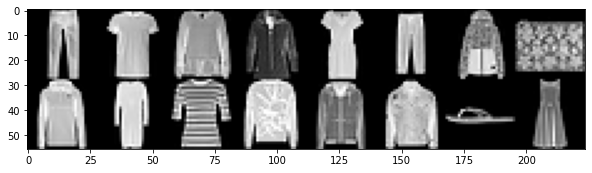

In [13]:
# make_grid() : 여러 이미지를 모아서 하나의 이미지로 
img = utils.make_grid(images, padding=0)

# Tensor -> Numpy
npimg = img.numpy()
print(npimg.shape)
print(labels)

# dataloader Tensor 이미지와 matplotlib의 차원 순서가 다름
# 색상(0), 세로(1), 가로(2) -> Transpose : 세로(1), 가로(2), 색상(0)
plt.figure(figsize=(10, 7))
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()

In [14]:
# 이미지 클래스
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

## DNN Classification

### DNN 구성하기

In [21]:
class Net(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        # Fully Connected한 선형 레이어
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 10)   # 마지막 출력값 10개는 분류 클래스의 수

    # 순전파 정의
    def forward(self, x):
        # 입력값을 랭크1 텐서로 변환
        x = x.view(-1, 28 * 28)
        
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc2(h1))
        output = self.fc3(h2)
        return output

### 모델 생성

In [24]:
# to() : 연산을 어디서 처리할 것인지 정의
model = Net().to(DEVICE)

### Optimizer

In [26]:
# 모델의 parameter와 학습률을 지정
optimizer = optim.SGD(model.parameters(), lr=0.01)

### 모델 학습 함수 정의

In [27]:
def train(model, train_loader, optimizer):
    # 모델 모드 설정 : 학습
    model.train()

    for idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(DEVICE), labels.to(DEVICE)

        # 기울기 초기화
        optimizer.zero_grad()

        # 모델 예측
        output = model(data)

        # Loss Function : Cross Entropy
        loss = F.cross_entropy(output, labels)

        # 오차 역전파
        loss.backward()

        # 가중치 수정
        optimizer.step()

### 모델 평가 함수 정의

In [33]:
def evaluate(model, test_loader):
    # 모델 모드 설정 : 평가
    model.eval()

    test_loss = 0   # 테스트셋 오차 초기화
    correct = 0     # 예측 성공 갯수 초기화

    with torch.no_grad():   # 기울기 계산 끄기
        for data, labels in test_loader:
            data, labels = data.to(DEVICE), labels.to(DEVICE)
            output = model(data)

            test_loss += F.cross_entropy(output, labels, reduction='sum').item()

            # 모델의 예측값(output에서 가장 큰 값을 가진 인덱스)
            pred = output.max(1, keepdim=True)[1]

            # 모델의 예측값(pred)과 정답(labels)이 일치하는지 확인
            # 모델이 맞춘 정답의 수 더하기
            correct += pred.eq(labels.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, test_accuracy

### 모델 학습, 평가 진행

In [34]:
for epoch in range(1, EPOCHS + 1):
    train(model, train_loader, optimizer)
    test_loss, test_accuracy = evaluate(model, test_loader)
    
    print(f'[{epoch}] Test Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.2f}%')

[1] Test Loss: 0.3341, Accuracy: 88.29%
[2] Test Loss: 0.3341, Accuracy: 88.42%
[3] Test Loss: 0.3319, Accuracy: 88.44%
[4] Test Loss: 0.3329, Accuracy: 88.37%
[5] Test Loss: 0.3330, Accuracy: 88.38%
[6] Test Loss: 0.3349, Accuracy: 88.38%
[7] Test Loss: 0.3337, Accuracy: 88.41%
[8] Test Loss: 0.3369, Accuracy: 88.38%
[9] Test Loss: 0.3338, Accuracy: 88.57%
[10] Test Loss: 0.3348, Accuracy: 88.50%
[11] Test Loss: 0.3353, Accuracy: 88.47%
[12] Test Loss: 0.3379, Accuracy: 88.38%
[13] Test Loss: 0.3380, Accuracy: 88.46%
[14] Test Loss: 0.3403, Accuracy: 88.35%
[15] Test Loss: 0.3431, Accuracy: 88.33%
[16] Test Loss: 0.3477, Accuracy: 88.16%
[17] Test Loss: 0.3529, Accuracy: 88.22%
[18] Test Loss: 0.3545, Accuracy: 88.09%
[19] Test Loss: 0.3558, Accuracy: 88.26%
[20] Test Loss: 0.3586, Accuracy: 88.08%
[21] Test Loss: 0.3651, Accuracy: 88.10%
[22] Test Loss: 0.3699, Accuracy: 87.89%
[23] Test Loss: 0.3662, Accuracy: 88.26%
[24] Test Loss: 0.3787, Accuracy: 87.97%
[25] Test Loss: 0.3798, A